In [69]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import plotly.express as px
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt

import os
import datetime
import pickle
import random

from jaxtyping import Float
from functools import partial

import wandb

In [70]:
import transformer_lens

In [71]:
DEVICE="cuda"

In [72]:
N_CTX = 64
D_VOCAB = 11  # 10 digits and a comma
cfg = transformer_lens.HookedTransformerConfig(
    n_layers=2,
    d_model=128,
    n_ctx=N_CTX,
    d_head=32,
    n_heads=4,
    d_mlp=None,
    d_vocab=D_VOCAB,
    act_fn="relu",
    seed=42,
    device=DEVICE,
    attn_only=True,
)
model = transformer_lens.HookedTransformer(cfg, move_to_device=True)

In [73]:
def load_model_state(model: transformer_lens.HookedTransformer, filename: str):
    assert os.path.isdir("models"), "Make a directory `models` with model state dicts"
    if not filename.startswith("models/"):
        filename = f"models/{filename}"
    with open(filename, "rb") as f:
        state_dict = pickle.load(f)
    model.load_state_dict(state_dict)

load_model_state(model, "addition_model_state_dict_2024-06-21T15-07.pkl")

In [74]:
def tokenize(c: str):
    return ord(c) - ord("0") if c.isdigit() else 10  # 10 is comma

def str_to_tokens(seq_str):
    return torch.tensor([tokenize(c) for c in seq_str], device=DEVICE)

In [75]:
tests = []

for _ in range(1000):
    a = random.randint(0, 500)
    b = random.randint(0, 500)
    test_example = f"{str(a).zfill(4)},{str(b).zfill(4)},"
    example_toks = str_to_tokens(test_example)
    if len(example_toks) < cfg.n_ctx:
        example_toks = F.pad(example_toks, (cfg.n_ctx - len(example_toks), 0), value=10)

    expected = a + b
    tests.append((example_toks, expected))

len(tests), tests[0]

(1000,
 (tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
          10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
          10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
           0,  1,  1,  4, 10,  0,  0,  2,  5, 10], device='cuda:0'),
  139))

In [76]:
correct_count = 0
incorrect = []
for (x, y) in tests:
    example_toks = x
    logits = model(example_toks)[:, -1, :]
    pred = logits.argmax(dim=-1)
    digits_ans = [str(pred[0].item())]

    for _ in range(3):
        example_toks = torch.cat([example_toks[1:], pred], dim=0)
        logits = model(example_toks)[:, -1, :]
        pred = logits.argmax(dim=-1)
        digits_ans.append(str(pred[0].item()))

    if y != int(''.join(digits_ans)):
        incorrect.append((x, y, digits_ans))
    else:
        correct_count += 1
correct_count, incorrect

(989,
 [(tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
           10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
           10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            0,  5,  9,  7, 10,  0,  4,  0,  8, 10], device='cuda:0'),
   1005,
   ['0', '9', '0', '5']),
  (tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
           10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
           10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            0,  5,  4,  9, 10,  0,  4,  5,  9, 10], device='cuda:0'),
   1008,
   ['0', '9', '0', '8']),
  (tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
           10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
           10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            0,  4,  8,  8, 10,  0,  5

In [77]:
example_str = f"0001,0099,"
example_toks = str_to_tokens(example_str)
if len(example_toks) < cfg.n_ctx:
    example_toks = F.pad(example_toks, (cfg.n_ctx - len(example_toks), 0), value=10)

logits, cache = model.run_with_cache(example_toks, remove_batch_dim=True)

In [78]:
example_toks.shape

torch.Size([64])

torch.Size([4, 64, 64])


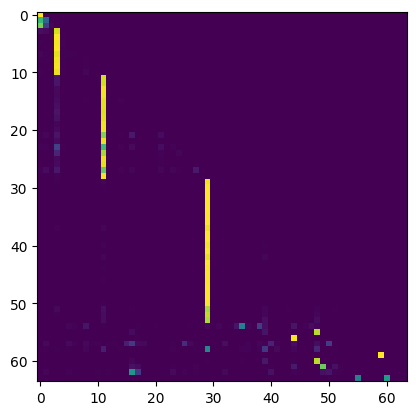

In [79]:
attn_pattern = cache["pattern", 0, "attn"]
print(attn_pattern.shape)
plt.imshow(attn_pattern[0].cpu())